# 利用测井数据识别岩性的人工神经网络方法
### 姓名：张恒建  学号：Z20010088  专业：资源与环境 声波测井方向 

测井，也叫地球物理测井，是利用岩层的电化学特性、导电特性、声学特性、放射性等地球物理特性，测量地球物理参数的方法。
利用测井得到的各种地层参数，可以计算地层的孔隙度、渗透率和含油(气)饱和度等信息，也可以用来判断地层的岩性。

## 1.导入所需模块

In [1]:
import tensorflow as tf
from tensorflow import keras        #TensorFlow与Keras： 构建和训练模型
import numpy as np                  #Numpy：             处理多维数组
import scipy.io as scio             #SCIpy：             读取数据文件
from prettytable import PrettyTable #PrettyTable：       画表格

## 2.导入测井数据

数据来源为相关竞赛提供的公开数据集，获取数据集与相应说明的地址为：https://xeek.ai/challenges/force-well-logs/overview 

原始的数据集包含挪威近海90多个井的测井记录，解释的岩相和岩石地层。测井记录包括测井名称（WELL），用于电缆测量的测得深度，x、y、z位置以及测井记录CALI、RDEP、RHOB、DHRO、SGR、GR、RMED、RMIC、NPHI、PEF、RSHA、DTC、SP、BS、ROP、DTS、DCAL、MUDWEIGHT。

由于原始的数据集大于10MB，所以最终的源数据welllogdata.mat文件是通过MATLAB将原始的数据集去掉空白列后取前160000行的数据，得到的一个160000*16的多维数组。

源数据welllogdata.mat用scio.loadmat打开后保存在字典中，其中数据部分保存在关键字“welllogdata”对应的值中。

In [2]:
dataFile='C:\\Users\\windwalker\\Desktop\\用测井数据划分岩性的人工神经网络方法\\welllogdata.mat'
welllog=scio.loadmat(dataFile)
welllogdata=welllog['welllogdata'][1:,:]
welllogdata.shape

(160000, 16)

源数据的前4列分别为地层的深度及x、y、z位置信息，与岩石性质无关。

源数据的第5~14列为各种测井方法得到的地层参数。

第16列为一个名为FORCE_2020_LITHOFACIES_CONFIDENCE的附加列（1：高，2：中，3：低），本次处理中忽略该列。

第15列为解释好的岩性标签，数值与岩性对应如下表：

In [3]:
label_value=[30000,65030,65000,80000,74000,70000,70032,88000,86000,99000,90000,93000]
class_names=["砂岩","砂岩/页岩","页岩","泥灰岩","白云石","石灰岩","白垩岩","石盐","硬石膏","凝灰岩","煤","基底"]
x= PrettyTable(["The lithology key","岩性"])
for i in range(12):
    x.add_row([label_value[i],class_names[i]])
print(x);

+-------------------+-----------+
| The lithology key |    岩性   |
+-------------------+-----------+
|       30000       |    砂岩   |
|       65030       | 砂岩/页岩 |
|       65000       |    页岩   |
|       80000       |   泥灰岩  |
|       74000       |   白云石  |
|       70000       |   石灰岩  |
|       70032       |   白垩岩  |
|       88000       |    石盐   |
|       86000       |   硬石膏  |
|       99000       |   凝灰岩  |
|       90000       |     煤    |
|       93000       |    基底   |
+-------------------+-----------+


## 3.数据的预处理

因为相近地层的岩性往往相似，因此需要打乱原始数据的顺序

删除数据集中包含空值的行

因为训练模型输出的标签值为0~11，所以将The lithology key转换为对应的整数

In [4]:
np.random.shuffle(welllogdata)                                         #因为相近地层的岩性往往相似 因此需要打乱原始数据的顺序
welllogdata_processing=welllogdata[~np.isnan(welllogdata).any(axis=1)] #删除包含空值的行
label=welllogdata_processing[:,14]                                     #label保存在数组的第15列
label_value=[30000,65030,65000,80000,74000,70000,70032,88000,86000,99000,90000,93000]
labelprocessing=np.zeros(len(label), dtype=int)                        #预分配内存
for i in range(len(label)):
    for j in range(len(label_value)):
        if label[i]==label_value[j]:
            labelprocessing[i]=j                                       #将label里的关键字变为0~11

## 4.划分训练集与测试集

按7:3的比例划分训练集与测试集

数据集的前4列为深度与位置坐标，与岩性判断无关，第16列为一个名为FORCE_2020_LITHOFACIES_CONFIDENCE的附加列（1：高，2：中，3：低），均舍弃不用 

In [5]:
train_proportion=0.7                                                                       #确定训练集比例为70%
train_data=welllogdata_processing[:int(train_proportion*len(welllogdata_processing)),4:14] #数据集的前四列为深度与位置坐标，舍弃不用
train_label=labelprocessing[:int(train_proportion*len(welllogdata_processing))]            
test_data=welllogdata_processing[int(train_proportion*len(welllogdata_processing))+1:,4:14]
test_label=labelprocessing[int(train_proportion*len(welllogdata_processing))+1:]

## 5.对训练集与测试集进行归一化处理

In [6]:
for i in range(10):
    train_data[:,i]=train_data[:,i]/max(welllogdata_processing[:,i]);
    test_data[:,i]=test_data[:,i]/max(welllogdata_processing[:,i]);

## 6.构建模型

使用Keras Sequential顺序模型，设置层为全连接层Dense，激活函数设置为relu，输入参数10个，输出参数12个

In [7]:
model = keras.Sequential([
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(12)
])

### 编译模型

在训练模型之前，需要配置学习过程，这是通过compile方法完成的。它接收三个参数：优化器optimizer、损失函数loss、评估标准metrics。

本模型使用Adam优化器，损失函数使用概率损失Probabilistic losses中的SparseCategoricalCrossentropy，评估标准为准确性指标Accuracy metrics中的Accuracy。

In [8]:
model.compile(optimizer='adam',              
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 7.训练模型

### 向模型馈送数据

Keras模型在输入数据和标签的Numpy矩阵上进行训练。为了训练一个模型，通常会使用fit函数,作用是以给定数量的轮次（数据集上的迭代）训练模型。

fit函数的默认参数定义如下：
fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)

本模型用到的参数有x、y和epochs，分别指训练集数组、训练集标签数组与训练模型迭代的最终轮次。

In [9]:
model.fit(train_data, train_label, epochs=20)

Epoch 1/20
1482/1482 [==============================] - 1s 548us/step - loss: 1.7032 - accuracy: 0.6486
Epoch 2/20
1482/1482 [==============================] - 1s 527us/step - loss: 0.8411 - accuracy: 0.7160
Epoch 3/20
1482/1482 [==============================] - 1s 526us/step - loss: 0.7071 - accuracy: 0.7713
Epoch 4/20
1482/1482 [==============================] - 1s 523us/step - loss: 0.6591 - accuracy: 0.7897
Epoch 5/20
1482/1482 [==============================] - 1s 526us/step - loss: 0.6405 - accuracy: 0.7926
Epoch 6/20
1482/1482 [==============================] - 1s 531us/step - loss: 0.6311 - accuracy: 0.7951
Epoch 7/20
1482/1482 [==============================] - 1s 513us/step - loss: 0.6240 - accuracy: 0.7984
Epoch 8/20
1482/1482 [==============================] - 1s 508us/step - loss: 0.6192 - accuracy: 0.7988
Epoch 9/20
1482/1482 [==============================] - 1s 528us/step - loss: 0.6143 - accuracy: 0.8001
Epoch 10/20
1482/1482 [==============================] - 1s 526u

## 8.评估准确率

通过evaluate来评估训练后模型的准确率，evaluate函数的默认参数定义如下：
evaluate(x=None, y=None, batch_size=None, verbose=1, sample_weight=None, steps=None)

本次用到的参数x、y与verbose分别为测试集、测试集标签

In [10]:
test_loss, test_acc = model.evaluate(test_data,test_label)
print('\nTest accuracy:', test_acc)

636/636 [==============================] - 0s 450us/step - loss: 0.5950 - accuracy: 0.8003

Test accuracy: 0.8003051280975342


## 9.参考

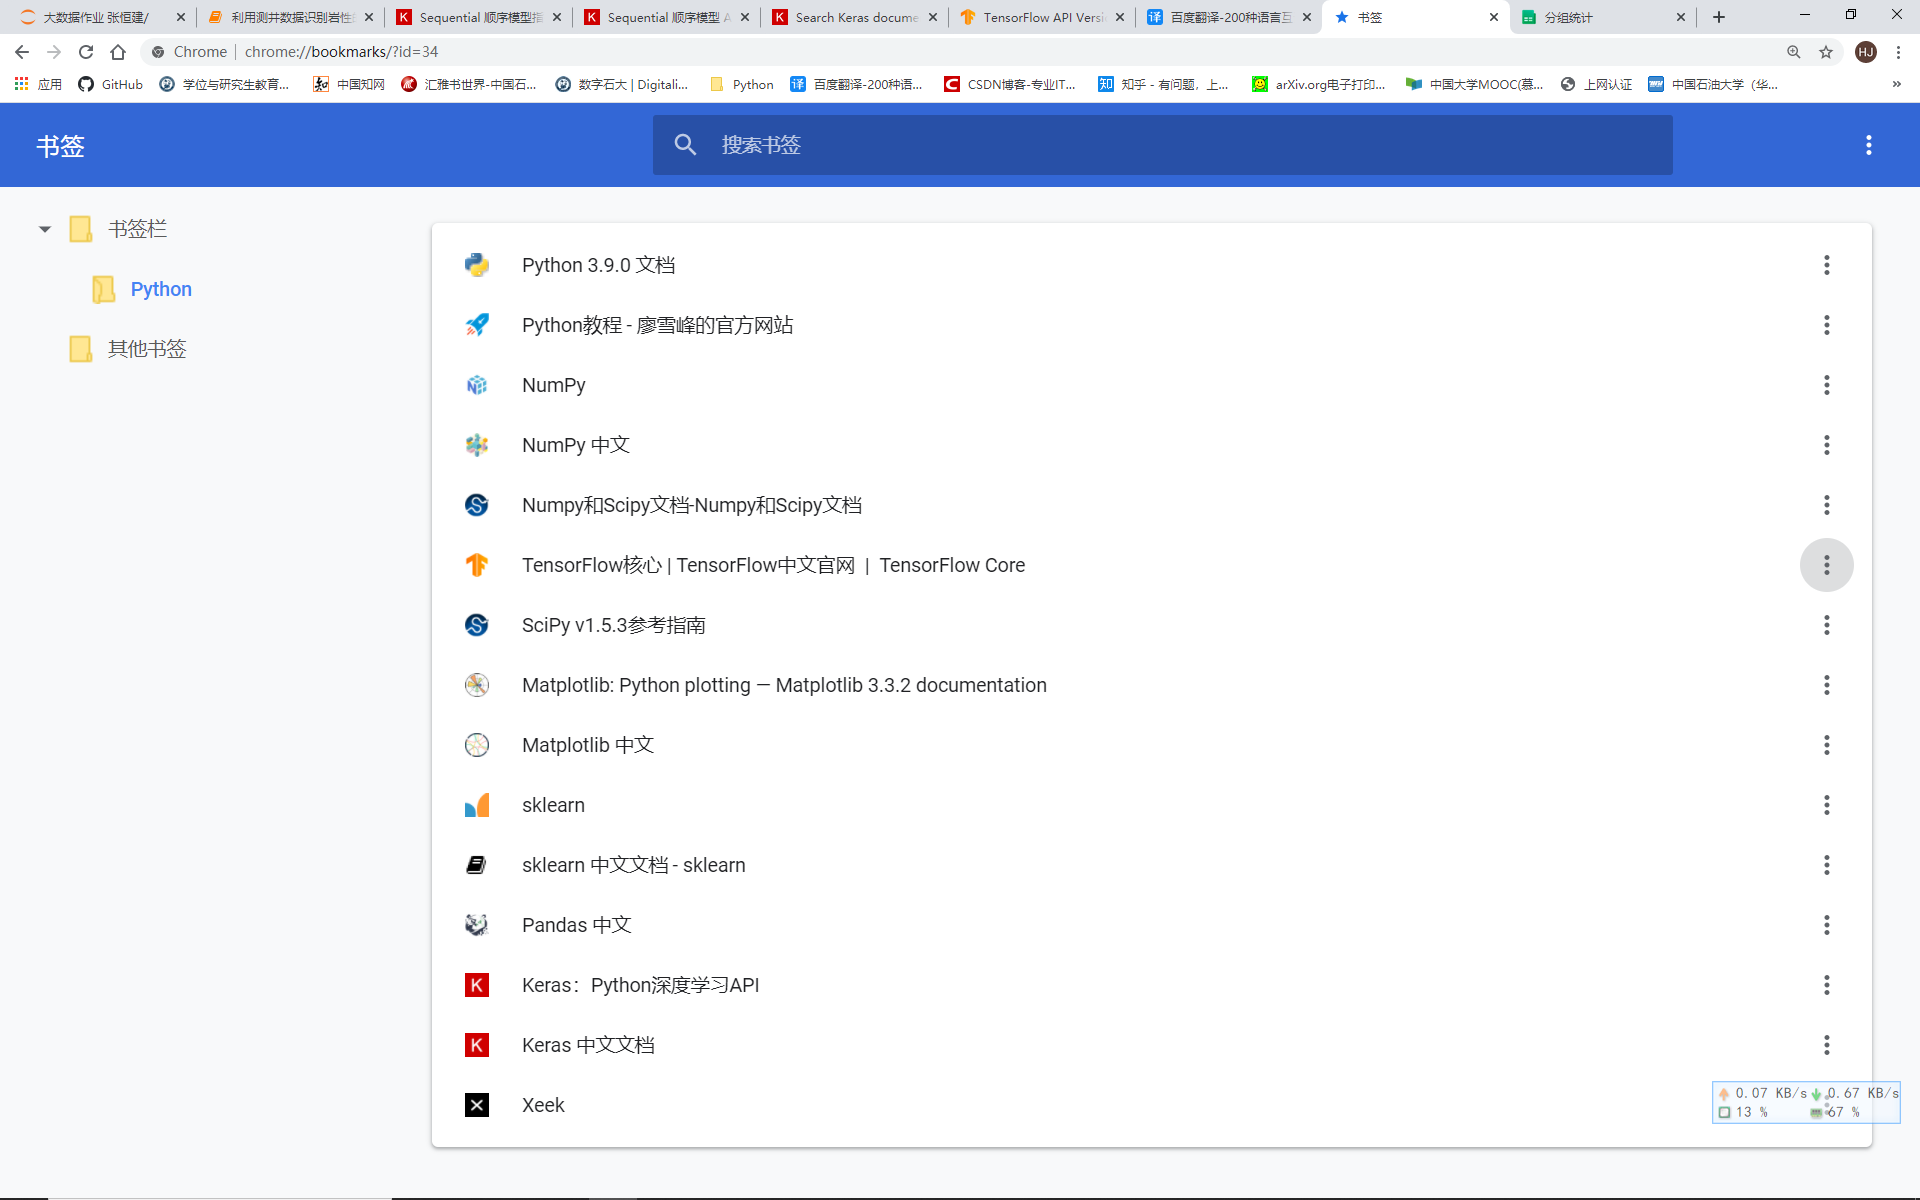